In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/corona-virus-report/covid_19_clean_complete.csv


In [2]:
!pip install calmap

In [3]:
import random
from urllib.request import urlopen

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import folium
import calmap

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML


In [4]:
covid_df = pd.read_csv('/kaggle/input/corona-virus-report/covid_19_clean_complete.csv', parse_dates=['Date'])

In [5]:
covid_df.head()

Province/State Country/Region      Lat      Long       Date  Confirmed  \
0            NaN       Thailand  15.0000  101.0000 2020-01-22          2   
1            NaN          Japan  36.0000  138.0000 2020-01-22          2   
2            NaN      Singapore   1.2833  103.8333 2020-01-22          0   
3            NaN          Nepal  28.1667   84.2500 2020-01-22          0   
4            NaN       Malaysia   2.5000  112.5000 2020-01-22          0   

   Deaths  Recovered  
0       0          0  
1       0          0  
2       0          0  
3       0          0  
4       0          0

In [6]:
covid_df.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
dtype: object

In [7]:
print('Number of data points : ', covid_df.shape[0])
print('Number of features : ', covid_df.shape[1])

Number of data points :  11960
Number of features :  8


Data Cleaning

In [8]:
#to indicate if any value is missing. Any missing values?
covid_df.isnull().values.any()

True

In [9]:
# Total missing values for each feature
covid_df.isnull().sum()

Province/State    6084
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [10]:
# replacing state missing values by "unknow"
covid_df['Province/State'] = covid_df['Province/State'].fillna('unknown')

In [11]:
# Replace with Mainland China to China
covid_df.replace('Mainland China', 'China', inplace = True)

In [12]:
covid_df.isnull().values.any()

False

In [13]:
import pandas_profiling
pandas_profiling.ProfileReport(covid_df)

In [14]:
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
# Active Case = confirmed - deaths - recovered
covid_df['Active'] = covid_df['Confirmed'] - covid_df['Deaths'] - covid_df['Recovered']
covid_df[cases] = covid_df[cases].fillna(0)

In [15]:
# latest data
covid_latest = covid_df[covid_df['Date'] == max(covid_df['Date'])].reset_index()
china_latest = covid_latest[covid_latest['Country/Region']=='China']
row_latest = covid_latest[covid_latest['Country/Region']!='China']

In [16]:
# condensed latest data
covid_latest_grouped = covid_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()


In [17]:
covid = covid_df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Active'].max()

In [18]:
covid = covid_df.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
covid = covid[covid['Date']==max(covid['Date'])].reset_index(drop=True)
covid.style.background_gradient(cmap='viridis')

Country with Confirmed and Deaths reported

In [19]:
temp_f = covid_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.style.background_gradient(cmap='Reds')

In [20]:
temp = temp_f[temp_f['Recovered']==0][['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp.reset_index(drop=True).style.background_gradient(cmap='Reds')

Country with all cases died

In [21]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Deaths']]
temp = temp[['Country/Region', 'Confirmed', 'Deaths']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Reds')

Country with all the cases which recovered

In [22]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

In [23]:
temp_f = china_latest_grouped[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp_f = temp_f.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.style.background_gradient(cmap='Pastel1_r')

State in the china which recovered all the cases

In [24]:
temp = china_latest_grouped[china_latest_grouped['Confirmed']==
                          china_latest_grouped['Recovered']]
temp = temp[['Province/State', 'Confirmed','Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

Plotting cases on the world map

In [25]:
# Ploting cases on world map
import folium
import math
world_map = covid_df[covid_df['Date'] == covid_df['Date'].max()]
map = folium.Map(location=[30, 30], tiles = "cartodbpositron", zoom_start=2.2)
for i in range(0,len(world_map)):
    folium.Circle(location=[world_map.iloc[i]['Lat'],
                            world_map.iloc[i]['Long']],
                            radius=(math.sqrt(world_map.iloc[i]['Confirmed'])*4000 ),
                            color='crimson',
                            fill=True,
                            fill_color='crimson').add_to(map)
map

In [26]:
# https://plot.ly/python/choropleth-maps/
fig = px.choropleth(covid_latest_grouped, locations="Country/Region", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="Country/Region", range_color=[1,7000], 
                    color_continuous_scale="aggrnyl", 
                    title='Countries with Confirmed Cases')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [27]:
# https://plot.ly/python/choropleth-maps/
import plotly.express as px

fig = px.choropleth(covid_latest_grouped, locations="Country/Region", locationmode='country names', 
                    color="Confirmed", hover_name="Country/Region", range_color=[1,50], color_continuous_scale="Sunsetdark", 
                    title='Countries with Confirmed Cases')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [28]:
fig = px.choropleth(covid_latest_grouped[covid_latest_grouped['Deaths']>0], locations="Country/Region", locationmode='country names',
                    color="Deaths", hover_name="Country/Region", range_color=[1,50], color_continuous_scale="Peach",
                    title='Countries with Deaths Reported')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [29]:
formated_gdf = covid_df.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], 
                     projection="natural earth", animation_frame="Date", 
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()


In [30]:
flg = covid_latest_grouped
flg.head()
fig = px.bar(flg.sort_values('Confirmed', ascending=False).head(20).sort_values('Confirmed', ascending=True), 
             x="Confirmed", y="Country/Region", title='Confirmed Cases', text='Confirmed', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Confirmed'])+10000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')
fig.show()

In [31]:
fig = px.bar(flg.sort_values('Deaths', ascending=False).head(20).sort_values('Deaths', ascending=True), 
             x="Deaths", y="Country/Region", title='Deaths', text='Deaths', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Deaths'])+500])
fig.update_traces(marker_color="#ff2e63", opacity=0.6, textposition='outside')
fig.show()

In [32]:
fig = px.bar(flg.sort_values('Recovered', ascending=False).head(20).sort_values('Recovered', ascending=True), 
             x="Recovered", y="Country/Region", title='Recovered', text='Recovered', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Recovered'])+10000])
fig.update_traces(marker_color='#21bf73', opacity=0.6, textposition='outside')
fig.show()

In [33]:
fig = px.bar(flg.sort_values('Active', ascending=False).head(20).sort_values('Active', ascending=True), 
             x="Active", y="Country/Region", title='Active', text='Active', orientation='h', 
             width=700, height=700, range_x = [0, max(flg['Active'])+3000])
fig.update_traces(marker_color='#fe9801', opacity=0.6, textposition='outside')
fig.show()

Date vs Confirmed

In [34]:
temp = covid_df.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()
temp = temp.reset_index()

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region', orientation='v', height=600,
             title='Confirmed', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.show()


Date vs Deaths

In [35]:
fig = px.bar(temp, x="Date", y="Deaths", color='Country/Region', orientation='v', height=600,
             title='Deaths', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.show()

Current cases

In [36]:
temp = covid_df.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region',title='New cases')
fig.show()

https://app.flourish.studio/visualisation/1571387/edit

In [37]:
# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML
HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1571387"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

Analysis on China

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c8a681a90>,
      dtype=object)

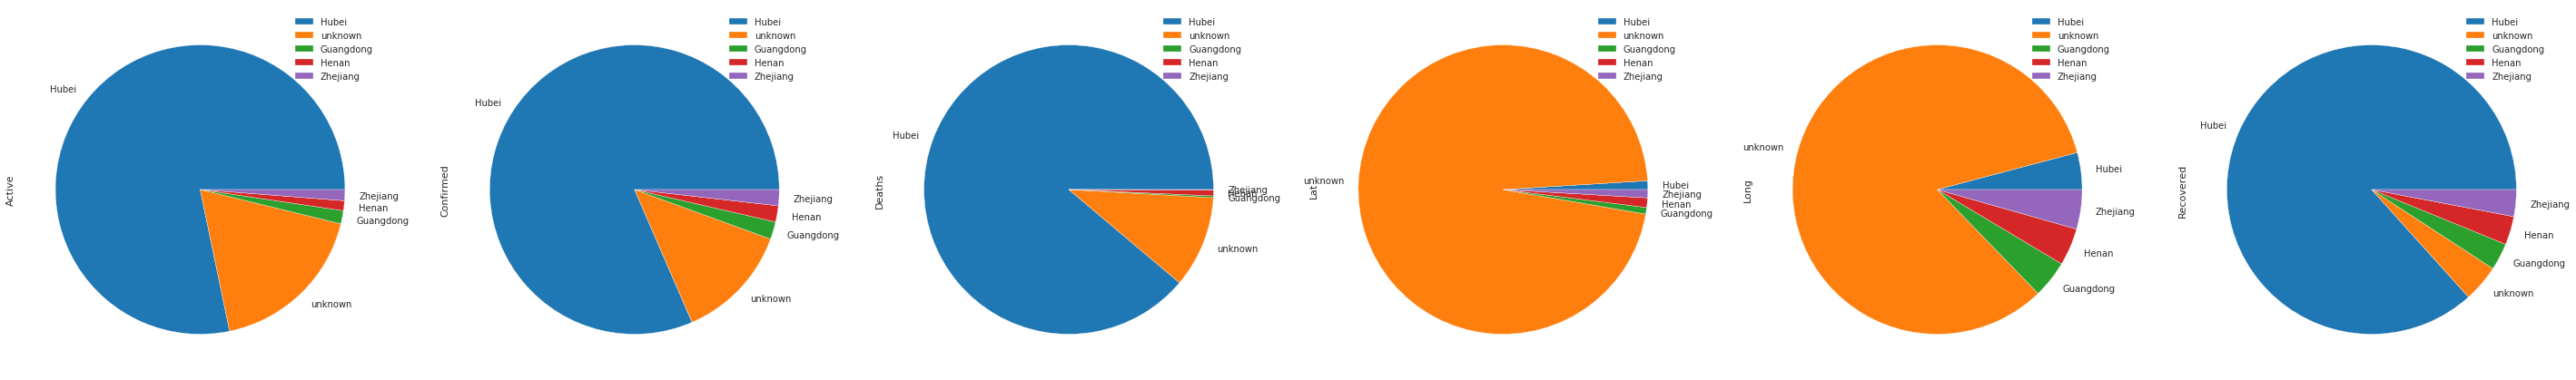

In [38]:
province_state = pd.pivot_table(covid_df,index=["Province/State"] ,aggfunc=np.sum).sort_values(by='Confirmed', ascending=False)
province_state[:5].plot(kind='pie', subplots=True, figsize=(50, 50))

In [39]:
# Produce quick summary for China with total numbers
china_latest = covid_latest[covid_latest['Country/Region']=='China']

covid_ch =  covid_latest[(covid_latest['Country/Region'] == 'China')]
china_df = china_latest.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

summary_china = china_df.sort_values('Date', ascending=False)
summary_china.head(1).style.background_gradient(cmap='OrRd')

Daily reported numbers in China

In [40]:
cl = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered'].sum()
cl = cl.reset_index().sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
# cl.head().style.background_gradient(cmap='rainbow')

ncl = cl.copy()
ncl['Affected'] = ncl['Confirmed'] - ncl['Deaths'] - ncl['Recovered']
ncl = ncl.melt(id_vars="Province/State", value_vars=['Affected', 'Recovered', 'Deaths'])

fig = px.bar(ncl.sort_values(['variable', 'value']), 
             y="Province/State", x="value", color='variable', orientation='h', height=800,
             title='Number of Cases in China', color_discrete_sequence=["#ff2e63", '#21bf73', '#fe9801'])
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

Analysis on India and Italy

In [41]:
India = covid_df[covid_df['Country/Region']=='India']
Italy = covid_df[covid_df['Country/Region']=='Italy']
row = covid_df[covid_df['Country/Region']!='India']

India_latest = covid_latest[covid_latest['Country/Region'] == 'India']
Italy_latest = covid_latest[covid_latest['Country/Region'] == 'Italy']
row_latest = covid_latest[covid_latest['Country/Region']!='India']

India_latest_grouped = India_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
Italy_latest_grouped = Italy_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

In [42]:
Italy_latest.head()

index Province/State Country/Region   Lat  Long       Date  Confirmed  \
16  11746        unknown          Italy  43.0  12.0 2020-03-13      17660   

    Deaths  Recovered  Active  
16    1266       1439   14955

In [43]:
India_latest_grouped.sort_values(by='Deaths', ascending=False).head().style.background_gradient(cmap='Pastel1_r')

In [44]:
plot_india_over_time = covid_df[(covid_df['Country/Region']=='India') & (covid_df['Confirmed']!=0)]

In [45]:
plot_italy_over_time = covid_df[(covid_df['Country/Region']=='Italy') & (covid_df['Confirmed']!=0)]

In [46]:
plot_india_over_time['day'] = pd.to_datetime(plot_india_over_time['Date'], format='%Y-%m-%d')
plot_italy_over_time['day'] = pd.to_datetime(plot_italy_over_time['Date'], format='%Y-%m-%d')

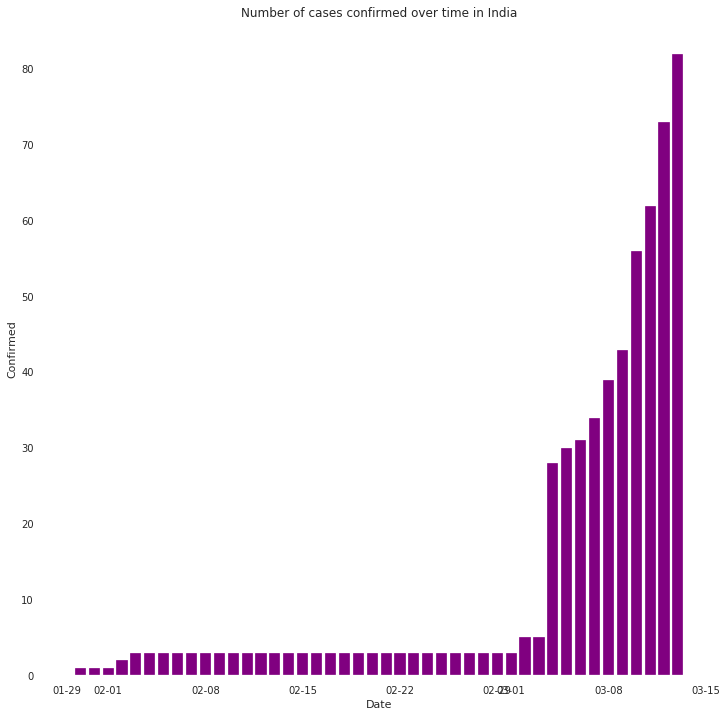

In [47]:
from matplotlib.dates import DateFormatter

# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.bar(plot_india_over_time['day'],
       plot_india_over_time['Confirmed'],
       color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Confirmed",
       title="Number of cases confirmed over time in India")

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

plt.show()

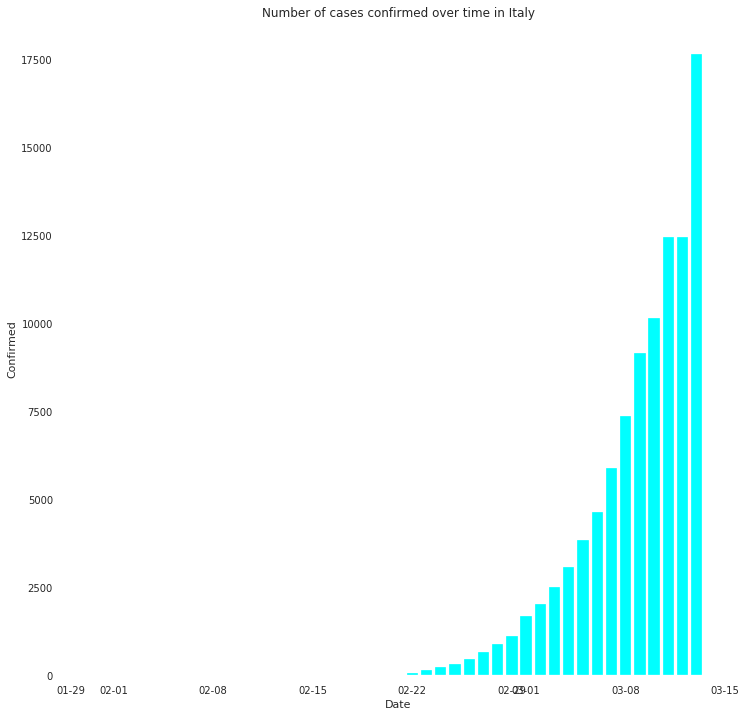

In [48]:
fig, bx = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
bx.bar(plot_italy_over_time['day'],
       plot_italy_over_time['Confirmed'],
       color='cyan')

# Set title and labels for axes
bx.set(xlabel="Date",
       ylabel="Confirmed",
       title="Number of cases confirmed over time in Italy")

# Define the date format
date_form = DateFormatter("%m-%d")
bx.xaxis.set_major_formatter(date_form)

plt.show()

Confirmed Cases in India

In [49]:
# India 
m = folium.Map(location=[20.5937, 78.9629], tiles='cartodbpositron',
               min_zoom=3, max_zoom=6, zoom_start=5)

for i in range(0, len(India_latest)):
    folium.Circle(
        location=[India_latest.iloc[i]['Lat'], India_latest.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(India_latest.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(India_latest.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(India_latest.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(India_latest.iloc[i]['Deaths'])+
                    '<li><bold>Recovered : '+str(India_latest.iloc[i]['Recovered']),
        radius=int(India_latest.iloc[i]['Confirmed'])**1).add_to(m)
m

Confirmed Cases in Italy

In [50]:
# India 
m = folium.Map(location=[41.8719, 12.5674], tiles='cartodbpositron',
               min_zoom=3, max_zoom=6, zoom_start=5)

for i in range(0, len(Italy_latest)):
    folium.Circle(
        location=[Italy_latest.iloc[i]['Lat'], Italy_latest.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(Italy_latest.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(Italy_latest.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(Italy_latest.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(Italy_latest.iloc[i]['Deaths'])+
                    '<li><bold>Recovered : '+str(Italy_latest.iloc[i]['Recovered']),
        radius=int(Italy_latest.iloc[i]['Confirmed'])**1).add_to(m)
m

I) Prediction model On India

In [51]:
covid_df.loc[covid_df['Country/Region']=='India']

Province/State Country/Region   Lat  Long       Date  Confirmed  Deaths  \
15           unknown          India  21.0  78.0 2020-01-22          0       0   
245          unknown          India  21.0  78.0 2020-01-23          0       0   
475          unknown          India  21.0  78.0 2020-01-24          0       0   
705          unknown          India  21.0  78.0 2020-01-25          0       0   
935          unknown          India  21.0  78.0 2020-01-26          0       0   
1165         unknown          India  21.0  78.0 2020-01-27          0       0   
1395         unknown          India  21.0  78.0 2020-01-28          0       0   
1625         unknown          India  21.0  78.0 2020-01-29          0       0   
1855         unknown          India  21.0  78.0 2020-01-30          1       0   
2085         unknown          India  21.0  78.0 2020-01-31          1       0   
2315         unknown          India  21.0  78.0 2020-02-01          1       0   
2545         unknown          India  21.0  78.0 2020-02-02          2       0   
2775         unknown          India  21.0  78.0 2020-02-03          3       0   
3005         unknown          India  21.0  78.0 2020-02-04          3       0   
3235         unknown          India  21.0  78.0 2020-02-05          3       0   
3465         unknown          India  21.0  78.0 2020-02-06          3       0   
3695         unknown          India  21.0  78.0 2020-02-07          3       0   
3925         unknown          India  21.0  78.0 2020-02-08          3       0   
4155         unknown          India  21.0  78.0 2020-02-09          3       0   
4385         unknown          India  21.0  78.0 2020-02-10          3       0   
4615         unknown          India  21.0  78.0 2020-02-11          3       0   
4845         unknown          India  21.0  78.0 2020-02-12          3       0   
5075         unknown          India  21.0  78.0 2020-02-13          3       0   
5305         unknown          India  21.0  78.0 2020-02-14          3       0   
5535         unknown          India  21.0  78.0 2020-02-15          3       0   
5765         unknown          India  21.0  78.0 2020-02-16          3       0   
5995         unknown          India  21.0  78.0 2020-02-17          3       0   
6225         unknown          India  21.0  78.0 2020-02-18          3       0   
6455         unknown          India  21.0  78.0 2020-02-19          3       0   
6685         unknown          India  21.0  78.0 2020-02-20          3       0   
6915         unknown          India  21.0  78.0 2020-02-21          3       0   
7145         unknown          India  21.0  78.0 2020-02-22          3       0   
7375         unknown          India  21.0  78.0 2020-02-23          3       0   
7605         unknown          India  21.0  78.0 2020-02-24          3       0   
7835         unknown          India  21.0  78.0 2020-02-25          3       0   
8065         unknown          India  21.0  78.0 2020-02-26          3       0   
8295         unknown          India  21.0  78.0 2020-02-27          3       0   
8525         unknown          India  21.0  78.0 2020-02-28          3       0   
8755         unknown          India  21.0  78.0 2020-02-29          3       0   
8985         unknown          India  21.0  78.0 2020-03-01          3       0   
9215         unknown          India  21.0  78.0 2020-03-02          5       0   
9445         unknown          India  21.0  78.0 2020-03-03          5       0   
9675         unknown          India  21.0  78.0 2020-03-04         28       0   
9905         unknown          India  21.0  78.0 2020-03-05         30       0   
10135        unknown          India  21.0  78.0 2020-03-06         31       0   
10365        unknown          India  21.0  78.0 2020-03-07         34       0   
10595        unknown          India  21.0  78.0 2020-03-08         39       0   
10825        unknown          India  21.0  78.0 2020-03-09         43       0   
11055        unknown          India  

In [52]:
for k,v in covid_df.groupby(['Country/Region','Province/State']):    
    for d in range(5):        
        covid_df.loc[v.index, f'Confirmed_Lag_{d}'] = v['Confirmed'].shift(d+1)
India_df = covid_df.fillna(0)

In [53]:
X_tr = [c for c in India_df.columns if 'Lag_' in c]
India_df[X_tr]

Confirmed_Lag_0  Confirmed_Lag_1  Confirmed_Lag_2  Confirmed_Lag_3  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
11955              0.0              0.0              0.0              0.0   
11956              0.0              0.0              0.0              0.0   
11957              0.0              0.0              0.0              0.0   
11958              0.0              0.0              0.0              0.0   
11959              0.0              0.0              0.0              0.0   

       Confirmed_Lag_4  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
11955              0.0  
11956              0.0  
11957              0.0  
11958              0.0  
11959              0.0  

[11960 rows x 5 columns]

In [54]:
from lightgbm import LGBMRegressor    
model = LGBMRegressor()
model.fit(X=India_df[X_tr], y=India_df['Confirmed'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
from datetime import timedelta
pred_steps = 23

history = India_df.loc[India_df['Country/Region']=='India']
history0 = history.iloc[-1]
pred_init = history0[X_tr].values
pred_init_confirmed = history0['Confirmed']

In [56]:
# Test out of sample input
print('History 0: ', pred_init)
pred_init = np.roll(pred_init, 1)
pred_init[0] = pred_init_confirmed
print('Pred 0: ', pred_init)

pred = np.zeros(pred_steps)
for d in range(pred_steps):
    y = model.predict(pred_init.reshape(1,-1))
    pred_init = np.roll(pred_init, 1)
    pred_init[0] = y    
    pred[d] = y
    
dt_rng = pd.date_range(start=history0['Date']+timedelta(days=1), end=history0['Date']+timedelta(days=pred_steps),freq='D').values
preds = pd.Series(data=pred, index=dt_rng, )

History 0:  [73.0 62.0 56.0 43.0 39.0]
Pred 0:  [82 73.0 62.0 56.0 43.0]


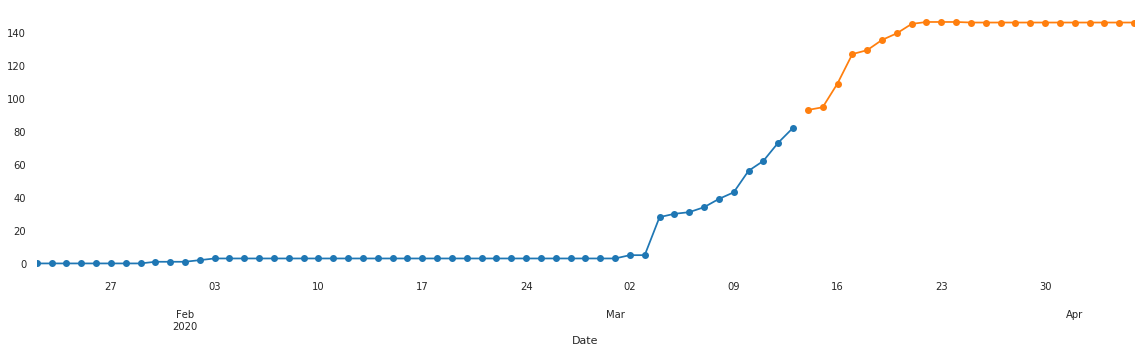

In [57]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(16,5))

history.set_index(['Date'])['Confirmed'].plot(ax=ax, marker='o')
preds.plot(ax=ax, marker='o')

plt.tight_layout()

In [58]:
covid_df.loc[covid_df['Country/Region']=='Italy']

Province/State Country/Region   Lat  Long       Date  Confirmed  Deaths  \
16           unknown          Italy  43.0  12.0 2020-01-22          0       0   
246          unknown          Italy  43.0  12.0 2020-01-23          0       0   
476          unknown          Italy  43.0  12.0 2020-01-24          0       0   
706          unknown          Italy  43.0  12.0 2020-01-25          0       0   
936          unknown          Italy  43.0  12.0 2020-01-26          0       0   
1166         unknown          Italy  43.0  12.0 2020-01-27          0       0   
1396         unknown          Italy  43.0  12.0 2020-01-28          0       0   
1626         unknown          Italy  43.0  12.0 2020-01-29          0       0   
1856         unknown          Italy  43.0  12.0 2020-01-30          0       0   
2086         unknown          Italy  43.0  12.0 2020-01-31          2       0   
2316         unknown          Italy  43.0  12.0 2020-02-01          2       0   
2546         unknown          Italy  43.0  12.0 2020-02-02          2       0   
2776         unknown          Italy  43.0  12.0 2020-02-03          2       0   
3006         unknown          Italy  43.0  12.0 2020-02-04          2       0   
3236         unknown          Italy  43.0  12.0 2020-02-05          2       0   
3466         unknown          Italy  43.0  12.0 2020-02-06          2       0   
3696         unknown          Italy  43.0  12.0 2020-02-07          3       0   
3926         unknown          Italy  43.0  12.0 2020-02-08          3       0   
4156         unknown          Italy  43.0  12.0 2020-02-09          3       0   
4386         unknown          Italy  43.0  12.0 2020-02-10          3       0   
4616         unknown          Italy  43.0  12.0 2020-02-11          3       0   
4846         unknown          Italy  43.0  12.0 2020-02-12          3       0   
5076         unknown          Italy  43.0  12.0 2020-02-13          3       0   
5306         unknown          Italy  43.0  12.0 2020-02-14          3       0   
5536         unknown          Italy  43.0  12.0 2020-02-15          3       0   
5766         unknown          Italy  43.0  12.0 2020-02-16          3       0   
5996         unknown          Italy  43.0  12.0 2020-02-17          3       0   
6226         unknown          Italy  43.0  12.0 2020-02-18          3       0   
6456         unknown          Italy  43.0  12.0 2020-02-19          3       0   
6686         unknown          Italy  43.0  12.0 2020-02-20          3       0   
6916         unknown          Italy  43.0  12.0 2020-02-21         20       1   
7146         unknown          Italy  43.0  12.0 2020-02-22         62       2   
7376         unknown          Italy  43.0  12.0 2020-02-23        155       3   
7606         unknown          Italy  43.0  12.0 2020-02-24        229       7   
7836         unknown          Italy  43.0  12.0 2020-02-25        322      10   
8066         unknown          Italy  43.0  12.0 2020-02-26        453      12   
8296         unknown          Italy  43.0  12.0 2020-02-27        655      17   
8526         unknown          Italy  43.0  12.0 2020-02-28        888      21   
8756         unknown          Italy  43.0  12.0 2020-02-29       1128      29   
8986         unknown          Italy  43.0  12.0 2020-03-01       1694      34   
9216         unknown          Italy  43.0  12.0 2020-03-02       2036      52   
9446         unknown          Italy  43.0  12.0 2020-03-03       2502      79   
9676         unknown          Italy  43.0  12.0 2020-03-04       3089     107   
9906         unknown          Italy  43.0  12.0 2020-03-05       3858     148   
10136        unknown          Italy  43.0  12.0 2020-03-06       4636     197   
10366        unknown          Italy  43.0  12.0 2020-03-07       5883     233   
10596        unknown          Italy  43.0  12.0 2020-03-08       7375     366   
10826        unknown          Italy  43.0  12.0 2020-03-09       9172     463   
11056        unknown          Italy  

In [59]:
for k,v in covid_df.groupby(['Country/Region','Province/State']):    
    for d in range(5):        
        covid_df.loc[v.index, f'Confirmed_Lag_{d}'] = v['Confirmed'].shift(d+1)
Italy_df = covid_df.fillna(0)

In [60]:
X_tr = [c for c in India_df.columns if 'Lag_' in c]
Italy_df[X_tr]

Confirmed_Lag_0  Confirmed_Lag_1  Confirmed_Lag_2  Confirmed_Lag_3  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
11955              0.0              0.0              0.0              0.0   
11956              0.0              0.0              0.0              0.0   
11957              0.0              0.0              0.0              0.0   
11958              0.0              0.0              0.0              0.0   
11959              0.0              0.0              0.0              0.0   

       Confirmed_Lag_4  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
11955              0.0  
11956              0.0  
11957              0.0  
11958              0.0  
11959              0.0  

[11960 rows x 5 columns]

In [61]:
from lightgbm import LGBMRegressor    
model = LGBMRegressor()
model.fit(X=Italy_df[X_tr], y=Italy_df['Confirmed'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [62]:
from datetime import timedelta
pred_steps = 23

history = Italy_df.loc[Italy_df['Country/Region']=='Italy']
history0 = history.iloc[-1]
pred_init = history0[X_tr].values
pred_init_confirmed = history0['Confirmed']

In [63]:
# Test out of sample input
print('History 0: ', pred_init)
pred_init = np.roll(pred_init, 1)
pred_init[0] = pred_init_confirmed
print('Pred 0: ', pred_init)

pred = np.zeros(pred_steps)
for d in range(pred_steps):
    y = model.predict(pred_init.reshape(1,-1))
    pred_init = np.roll(pred_init, 1)
    pred_init[0] = y    
    pred[d] = y
    
dt_rng = pd.date_range(start=history0['Date']+timedelta(days=1), end=history0['Date']+timedelta(days=pred_steps),freq='D').values
preds = pd.Series(data=pred, index=dt_rng, )

History 0:  [12462.0 12462.0 10149.0 9172.0 7375.0]
Pred 0:  [17660 12462.0 12462.0 10149.0 9172.0]


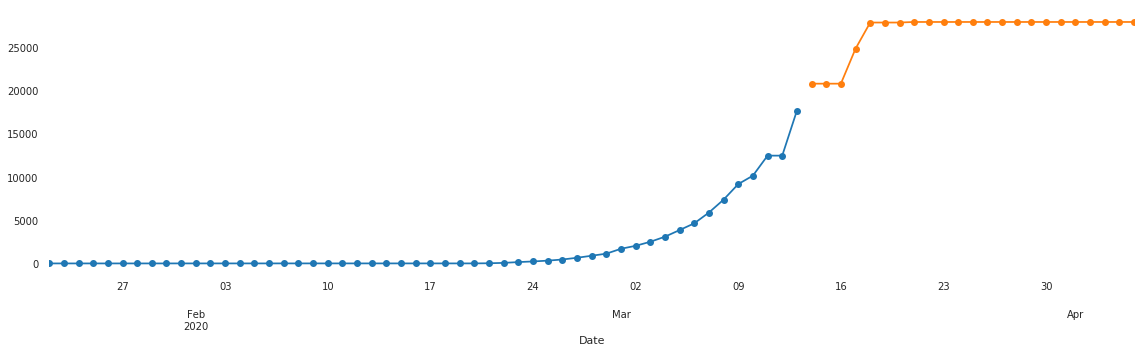

In [64]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(16,5))

history.set_index(['Date'])['Confirmed'].plot(ax=ax, marker='o')
preds.plot(ax=ax, marker='o')

plt.tight_layout()